### First Heuristic - Preliminary implementation
#### Description

If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.

In [1]:
# Import relevant packages.
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
withdraw_transactions_df = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_transactions_df["recipient_address"] = withdraw_transactions_df["recipient_address"].str.lower()
withdraw_transactions_df["block_timestamp"] = withdraw_transactions_df["block_timestamp"].apply(pd.Timestamp)

deposit_transactions_df = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_transactions_df["block_timestamp"] = deposit_transactions_df["block_timestamp"].apply(pd.Timestamp)

### Function summary: addresses_to_transactions

Given a transactions DataFrame, returns a dictionary with the unique addresses of the transactions data as keys and a list of tuples as values. The tuples consist on the hash of the transaction with the address as the corresponding key in the first index, and the timestamp of the transaction in the second index. 

For example, if the address 0x6c6e4816ecfa4481472ff88 has made transaction with a hash 0x7f851ba1d7292ca565961073a111 and timestamp 1, and another transaction with hash 0x8f851ba1d7192ca565961073a9191 and timestamp 2, then the dictionary returned will be:

```
{"0x6c6e4816ecfa4481472ff88": [("0x7f851ba1d7292ca565961073a111", timestamp1), ("0x8f851ba1d7192ca565961073a9191", timestamp2)]
```

In [3]:
def addresses_to_transactions(transactions_df):
    
    # Initialize empty dictionary to store addresses and associated transactions.
    
    address_to_transactions_dict = {}
    
    # We iterate over every transaction in the transactions DataFrame.
    
    for row in tqdm(transactions_df.itertuples(), mininterval=5, total=transactions_df.shape[0]):
        '''
        We check if the address of the current transaction in the iteration is already in the 
        dictionary. If it isn't, then we initialize that key and the list with the tuple. The
        tuple will consist of the hash and the timestamp of the current transaction.
        
        If the key already exists, we append to the associated list the tuple of the hash and
        timestamp of the current transaction.
        '''
        
        if row.from_address not in set(address_to_transactions_dict.keys()):
            address_to_transactions_dict[row.from_address] = [(row.hash, row.block_timestamp)]
        else:
            address_to_transactions_dict[row.from_address].append((row.hash, row.block_timestamp))
    
    # The dictionary with the addresses and transactions is returned.
    
    return address_to_transactions_dict

### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and a dictionary corresponding to what is returned by function addresses_to_transactions.

It returns a tuple:

* (True, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.

* (False, None): When no such deposit was found

In [4]:
def same_deposit_and_recipient_address_heuristic(withdraw_transaction, deposit_addresses_to_transactions):
    
    '''
    Check if the address of the withdraw tx is in the deposit_addresses_to_transactions keys.
    If it is, then a list is created with the hashes of all the deposit txs with the same address and
    with an earlier timestamp than the withdraw tx.
    If the address is not in the deposit_addresses_to_transactions dictionary, (False, None) is returned.
    '''
    
    if withdraw_transaction.recipient_address in set(deposit_addresses_to_transactions.keys()):
        
        # Only the transactions with earlier timestamps are selected for the list same_deposit_address_hashes.
        same_deposit_address_hashes = [tx_hash[0] for tx_hash in deposit_addresses_to_transactions[withdraw_transaction.recipient_address] if tx_hash[1] <= withdraw_transaction.block_timestamp]
        
        # Final check to assert that list is not empty.
        if len(same_deposit_address_hashes) > 0:
            return (True, same_deposit_address_hashes)
        else:
            return (False, None)
        
    return (False, None)

In [5]:
# deposit_addresses_to_transactions = addresses_to_transactions(deposit_transactions_df)


### Function summary: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction. Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.


In [14]:
def apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df):
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    deposit_addresses_and_transactions = addresses_to_transactions(deposit_transactions_df)
    
    same_deposit_address_hashes = {}
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
    
    for withdraw_row_tuple in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=15):
        deposit_hashes = same_deposit_and_recipient_address_heuristic(withdraw_row_tuple, deposit_addresses_and_transactions)
        # print(deposit_hashes)

        if deposit_hashes[0]:
            same_deposit_address_hashes[withdraw_row_tuple.hash] = deposit_hashes[1]

    # Return the dictionary with the links
    
    return same_deposit_address_hashes

In [7]:
hashes_dict = apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83782/83782 [01:49<00:00, 766.79it/s]


In [8]:
# Count of deposit transactions linked to withdraws.
linked_deposits_count = list(map(lambda x: len(x), hashes_dict.values()))

In [9]:
len(linked_deposits_count)

16659

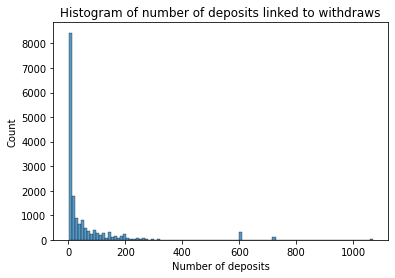

In [13]:
sns.histplot(data=linked_deposits_count, bins=100)
plt.title("Histogram of number of deposits linked to withdraws")
plt.xlabel("Number of deposits")
plt.show()